In [13]:
import os
import uuid

from keras.applications.vgg16 import preprocess_input

import keras
from keras import Model, Sequential
from keras.layers import Dense
from tensorflow.keras.utils import load_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import img_to_array
from elasticsearch import Elasticsearch

import pandas as pd

In [14]:
vgg16_model = VGG16()

model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

model.layers.pop()

# Freeze the layers
for layer in model.layers:
    layer.trainable = False




In [4]:
import cv2


In [15]:
data = pd.read_csv("E://INDP3AIM//indexation//bdimage//data.csv")
print(data.head())

   Unnamed: 0          id        userid                                 title  \
0           0  3889087403  25065987@N05       Light House on Lake Ponchatrain   
1           1  3889881036  25065987@N05        Ship Wreck on Lake Ponchatrain   
2           2  3873511228  25065987@N05  Fuchs - Lafayette No 2 - New Orleans   
3           3  3872700199  25065987@N05    Greenwood & Cypress Grove Cemetery   
4           4  3873466366  25065987@N05                               Warning   

                                                tags   latitude  longitude  \
0  {moon,lighthouse,reflection,louisiana,moonligh...  30.380316 -90.169172   
1  {light,moon,reflection,louisiana,shipwreck,nor...  30.377540 -90.163378   
2  {cemetery,grave,louisiana,neworleans,vault,cry...  29.934677 -90.091345   
3  {door,cemetery,rust,louisiana,neworleans,chain...  29.980159 -90.112062   
4  {cemetery,grave,warning,louisiana,neworleans,t...  29.980159 -90.112062   

   views           date_taken        date_up

In [10]:
len(data)

1000000

In [19]:
#stocker les urls des images
urlList = []
for i in range (len(data)): 
     url = "http://farm"+str(data.loc[i,"flickr_farm"])+".staticflickr.com/"+str(data.loc[i,"flickr_server"])+"/"+str(data.loc[i,"id"])+"_"+str(data.loc[i,"flickr_secret"])+".jpg"
     urlList.append(url)
     print(url)


http://farm3.staticflickr.com/2643/3889087403_26cba511d3.jpg
http://farm3.staticflickr.com/2537/3889881036_e910ee3ea3.jpg
http://farm3.staticflickr.com/2487/3873511228_797a76c582.jpg
http://farm3.staticflickr.com/2453/3872700199_7f262513ca.jpg
http://farm3.staticflickr.com/2473/3873466366_caca02e548.jpg
http://farm3.staticflickr.com/2488/3872664227_9a9dc1786c.jpg
http://farm7.staticflickr.com/6175/6265230574_2eabe44170.jpg


In [75]:
##### url to image
from PIL import Image
import requests
from io import BytesIO
images = []
for i in range(len(urlList)) :
    response = requests.get(urlList[i])
    img = BytesIO(response.content)
    images.append(img)
    print(i)


0
1
2
3
4


In [76]:
print(len(images))

5


In [77]:
from PIL import Image
from PIL import UnidentifiedImageError

features =[]
t = 0
for i in range (len(images)):
    t = t+1
    img_path = images[i]
    try:
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        print (image.shape)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        # Pass image into model to get encoded features
        feature = model.predict(image, verbose=0)
        features.append(feature)
    except UnidentifiedImageError:
        features.append([[0.]*4096])

    print(t)

(224, 224, 3)
1
(224, 224, 3)
2
(224, 224, 3)
3
(224, 224, 3)
4
(224, 224, 3)
5


In [78]:
print(feature.shape)

(1, 4096)


In [18]:
#rendre les features en dataframe puis en fichier csv
import numpy as np
print(feature.shape)
features=np.reshape(features,(30975,4096))
df = pd.DataFrame(features)
df.to_csv('featurez.csv', index=True, sep=',')


(1, 4096)


In [19]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.812889,0.930624,0.230900,1.372325,0.000000,4.191051,2.646338,0.040431,0.561439,0.0,...,1.027952,2.083375,3.618190,0.000000,0.000000,0.000000,0.898598,0.000000,3.745131,0.0
1,0.958172,2.307177,1.423192,0.000000,3.767015,0.962409,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,2.791762,0.000000,0.000000,1.075603,0.000000,4.659945,0.000000,0.0
2,0.328624,0.350225,0.603718,1.888740,5.739264,0.124329,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.152801,0.000000,0.000000,3.180523,3.888602,4.399487,0.000000,0.0
3,0.000000,4.137857,0.000000,0.000000,2.834232,0.000000,0.000000,0.000000,0.000000,0.0,...,1.524894,0.000000,0.000000,0.779876,3.405499,0.000000,0.760067,0.000000,3.174615,0.0
4,2.372370,1.243451,0.695294,0.503452,1.462122,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.844212,0.000000,0.185295,0.0


In [83]:
#faire la reduction des features
import numpy as np
import numpy as np

from sklearn.preprocessing import MinMaxScaler
# Standardizing the features
features = np.reshape(features,(3975,4096))
standarized_features = MinMaxScaler().fit_transform(features)
print(standarized_features)

[[0.34264857 0.15323532 0.162241   ... 0.         0.99999994 0.        ]
 [0.4038882  0.516669   1.         ... 1.         0.         0.        ]
 [0.13852116 0.         0.4241997  ... 0.94410706 0.         0.        ]
 [0.         1.         0.         ... 0.         0.84766454 0.        ]
 [0.99999994 0.23582694 0.48854524 ... 0.         0.04947615 0.        ]]


In [ ]:
#95% of variance
from sklearn.decomposition import PCA
featurez=np.reshape(standarized_features,(30975,4096))
df = pd.DataFrame(featurez)
df.to_csv('featurez_standarised.csv', index=True, sep=',')


In [ ]:
df = pd.read_csv('featurez_standarised.csv',index=False)

In [26]:

df.iloc[:,1:]

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.049384,0.063380,0.013792,0.109255,0.000000,0.403299,0.189645,0.001263,0.056787,0.0,...,0.056894,0.114263,0.246682,0.000000,0.000000,0.000000,0.069867,0.000000,0.263508,0.000000
1,0.058210,0.157131,0.085012,0.000000,0.145998,0.092611,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.190338,0.000000,0.000000,0.112555,0.000000,0.320697,0.000000,0.000000
2,0.019964,0.023852,0.036062,0.150368,0.222437,0.011964,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.010418,0.000000,0.000000,0.332822,0.302342,0.302772,0.000000,0.000000
3,0.000000,0.281809,0.000000,0.000000,0.109846,0.000000,0.000000,0.000000,0.000000,0.0,...,0.084398,0.000000,0.000000,0.086041,0.243122,0.000000,0.059096,0.000000,0.223366,0.000000
4,0.144124,0.084685,0.041532,0.040081,0.056667,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.298891,0.000000,0.013037,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30970,0.000000,0.173657,0.000000,0.464583,0.000000,0.067498,0.077920,0.000000,0.638858,0.0,...,0.080175,0.000000,0.005554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30971,0.000000,0.392606,0.000000,0.000000,0.000000,0.153989,0.188352,0.000000,0.000000,0.0,...,0.047421,0.000000,0.000000,0.000000,0.037103,0.225229,0.000000,0.000000,0.000000,0.134053
30972,0.017307,0.000000,0.000580,0.109030,0.125215,0.133688,0.183340,0.000000,0.013210,0.0,...,0.201650,0.000000,0.159768,0.000000,0.208829,0.221412,0.036627,0.000000,0.000000,0.000000
30973,0.000000,0.112708,0.000000,0.211955,0.038024,0.000000,0.376953,0.000000,0.290259,0.0,...,0.171574,0.000000,0.093746,0.000000,0.098032,0.388453,0.089528,0.000000,0.000000,0.000000


In [27]:
standarized_features = df.iloc[:,1:].to_numpy()

In [26]:
print(len(standarized_features))

7


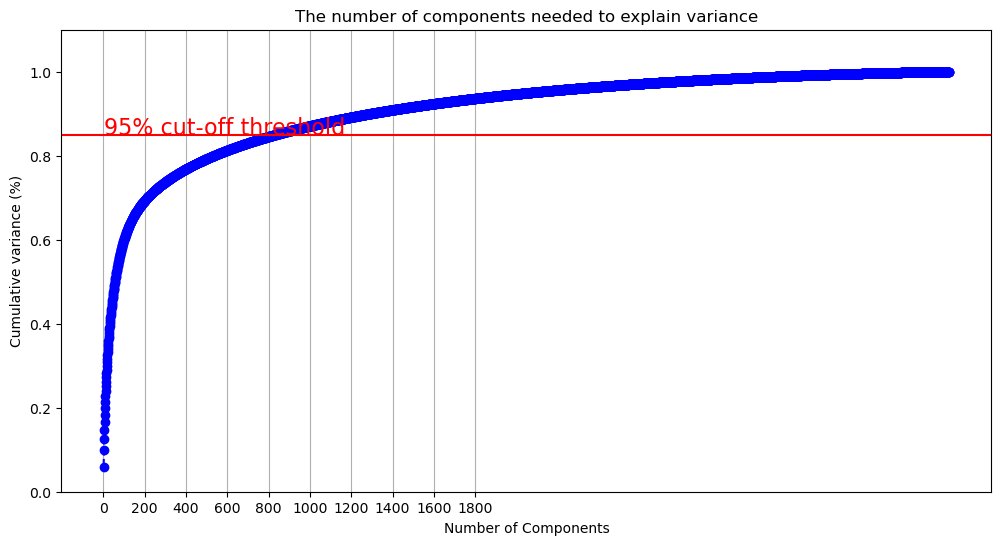

In [46]:
#on cherche le nombre de component optimale pour minimiser nos features à variance = 95% 
from sklearn.decomposition import PCA
import numpy as np

pca = PCA().fit(standarized_features)

#matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 4097, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 2000, step=200)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.85, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [47]:
pca = PCA(n_components = 900)
pca.fit(standarized_features)
reduced_features = pca.transform(standarized_features)
reduced_features_df = pd.DataFrame(reduced_features)
reduced_features_df.to_csv('reduced_featurez.csv', index=False, sep=',')

In [73]:
len(reduced_features_df)

30975

In [50]:
#creer un fichier qui contient le pca sur l'echantillon de 4096 images
import pickle
pickle.dump(pca, open("pca.pkl","wb"))
pickle.dump(reduced_features_df,open("reduced.pkl","wb"))

In [84]:
#reload le pca lorsque on va travailler sur autre echantillon d'image
from sklearn.decomposition import PCA
import pickle

pca_reload = pickle.load(open("pca.pkl",'rb'))
result_new = pca_reload.transform(standarized_features)

In [99]:
settings ={
  "settings": {
    "index": {
      "number_of_shards": 2,
      "number_of_replicas": 1
    }
  },
  "mappings" : {
  "dynamic": False,
  "properties": {
      "imageId": { "type": "keyword" },
      "feature_vector": {
          "type": "elastiknn_dense_float_vector",
          "elastiknn": {
            "dims": 785,
            "model": "lsh",
            "similarity": "l2",
            "L": 60,
            "k": 3,
            "w": 2
          }
    },
    "tags": { "type": "text" },
    "url":{"type":"text","index":False}
  }
}
}

In [102]:
import json
from elasticsearch import Elasticsearch
es = Elasticsearch("http://127.0.0.1:9200")
IndexName = 'abc'
my = es.indices.create(index=IndexName,  body=settings)

C:\Users\pc\AppData\Local\Temp\ipykernel_18476\2717431255.py:5: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  my = es.indices.create(index=IndexName,  body=settings)
C:\Users\pc\AppData\Local\Temp\ipykernel_18476\2717431255.py:5: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.
  my = es.indices.create(index=IndexName,  body=settings)


In [158]:
es.indices.get_alias()

C:\Users\pc\AppData\Local\Temp\ipykernel_16308\4215777434.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.
  es.indices.get_alias()


ObjectApiResponse({'featurezz': {'aliases': {}}})

In [165]:
requests = []
for i in range(24855,30975):
    request = {}
    request["imageId"] = i
    request["tags"] = data.loc[i,"tags"]
    request["feature_vector"] = reduced_features_df.iloc[i,:].tolist()
    request['url'] = urlList[i]
    requests.append(request)



In [166]:
#partie indexation
from elasticsearch import helpers

try:
    res = helpers.bulk(es, requests, index="featurezz")
    print("Working")
except Exception as e:
    print(e)

C:\Users\pc\AppData\Local\Temp\ipykernel_16308\845938520.py:5: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.
  res = helpers.bulk(es, requests, index="featurezz")


Working


In [90]:
feature = result_new[0].tolist()

In [91]:
len(feature)

900

In [169]:
#search  word
body = {
            "query":{
            "match": {
              "tags": "moon",
            }
          }
        }
my = es.search(index="featurezz", body=body)
print(my)

C:\Users\pc\AppData\Local\Temp\ipykernel_16308\1509133862.py:9: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  my = es.search(index="featurezz", body=body)


{'took': 2321, 'timed_out': False, '_shards': {'total': 2, 'successful': 2, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 65, 'relation': 'eq'}, 'max_score': 8.294182, 'hits': [{'_index': 'featurezz', '_type': '_doc', '_id': 'tFW7L4QBtvQziCixG4Lp', '_score': 8.294182, '_source': {'imageId': 642, 'tags': '{moon,stars,chocolate,galaxy}', 'feature_vector': [-0.49023891410334525, 0.4925598942424413, 0.6474027433779875, 0.15264671946443972, -0.5576032639404168, 0.588129463008126, 0.4385193244804197, 0.337495449843784, -0.05892740328577391, 0.006034330436609144, -0.6369531077844495, -1.0209132177733686, 0.22646117268822022, -0.24223889874804472, -0.2205876040903518, 0.13268406107718664, 0.3645225431884421, -0.19691734875979097, -0.2572214581185001, -0.3093921320923262, -0.15057559210444224, -0.26324629296058377, -0.38727752392259723, -0.5821106023509035, -0.43841754054126425, -0.5227626972231285, 0.6295257569155237, -0.06792147881597765, -0.32246221419717186, 0.47072877777120925, -

C:\Users\pc\AppData\Local\Temp\ipykernel_16308\1509133862.py:9: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.
  my = es.search(index="featurezz", body=body)


In [97]:
#search image
from elasticsearch import Elasticsearch
es = Elasticsearch("http://127.0.0.1:9200")
body = {
            "query":{
            "elastiknn_nearest_neighbors": {
              "field": "feature_vector",
              "vec": {
                "values": feature
              },
              "model": "exact",
              "similarity": "l2",
              "candidates": 50
            }
          }
        }



mz = es.search(index="featurezz", body=body, size=6)


C:\Users\pc\AppData\Local\Temp\ipykernel_18476\1341603631.py:20: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  mz = es.search(index="featurezz", body=body, size=6)
C:\Users\pc\AppData\Local\Temp\ipykernel_18476\1341603631.py:20: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.14/security-minimal-setup.html to enable security.
  mz = es.search(index="featurezz", body=body, size=6)


In [98]:
print(mz)

{'took': 949, 'timed_out': False, '_shards': {'total': 2, 'successful': 2, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 0.043329302, 'hits': [{'_index': 'featurezz', '_type': '_doc', '_id': 'MlW7L4QBtvQziCixFoCU', '_score': 0.043329302, '_source': {'imageId': 0, 'tags': '{moon,lighthouse,reflection,louisiana,moonlight,nightshots,madisonville,lakeponchatrain}', 'feature_vector': [1.6321267857906092, -0.6484175491255877, -0.3394200382605392, 0.9197672815001108, 0.5619738587984748, 0.9717198172928037, 0.4908666773536134, -0.3294658887205109, 0.1355969903469315, -0.25759506567239, 0.8402690535010507, -0.9599001829234134, 0.3914181479411088, 0.38915351940680104, -0.5604933413791906, -0.008925172014360688, -0.8683040990670989, -0.8214727937175504, -0.3193221386105076, 1.4647457113050983, -0.005673665608250053, -0.02282399436727581, -0.3633244179776581, -0.7244814362231119, -0.3319408047274615, 0.27559779040721893, 0.03136479127982033, 0.0651